In [1]:
import tensorflow as tf
import numpy as np
import pickle
import tensorflow.examples.tutorials.mnist.input_data as mnist
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import scipy.misc
import os, gzip
%matplotlib inline

In [113]:
def load_mnist(dataset_name):
    data_dir = os.path.join("./data", dataset_name)

    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1.0

    return X / 255., y_vec

In [114]:
data_x,data_y = load_mnist("mnist")
data = [data_x, data_y]
num_train = data_x.shape[0]
shape_img = [-1,28,28,1]

In [115]:
data_x[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [116]:
# # Get data from mnist
# data = input_data.read_data_sets('MNIST_data', one_hot=True)
# data_train = data.train.images
# label_train = data.train.labels
# num_train, shape_img = data.train.images.shape
# shape_img = [-1,28,28,1]

In [117]:
def get_y_code():
    y_example_code = np.zeros((100,12), dtype=np.float)
    final_codes=[]
    for k in range(10):
        final_codes.append(list(k*np.ones(10)))
    final_codes = np.array(final_codes)
    final_codes = final_codes.reshape(100,-1)
    for i,j in enumerate(final_codes):
        y_example_code[i,int(j[0])]=1.0
    return y_example_code

In [118]:
def set_input(noise_shape, image_shape):
    # image_shape = (num_exaple, height, width, depth)
    
    inputs_image = tf.placeholder(tf.float32, 
                                [None, image_shape[1], image_shape[2], image_shape[3]],
                                 name='inputs_image')
    inputs_noise = tf.placeholder(tf.float32,
                                 [None, noise_shape], name='inpute_noise')
    y = tf.placeholder(tf.float32, [None, 12], name='y')
    return inputs_image, inputs_noise, y

In [119]:
def conv2d(inputs, filters, kernel_size, strides, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        conv = tf.layers.conv2d(inputs, filters=filters, kernel_size=4, strides=strides, 
                         kernel_initializer=tf.truncated_normal_initializer(stddev=stddev),
                         bias_initializer=tf.constant_initializer(0.0),padding='same')
        return conv

In [120]:
def conv2d_transpose(inputs, filters, kernel_size, strides, stddev=0.02, name="conv2d_transpose"):
    with tf.variable_scope(name):
        conv_transpose = tf.layers.conv2d_transpose(
                         inputs=inputs, filters=filters, kernel_size=kernel_size,strides=strides, 
                         kernel_initializer=tf.truncated_normal_initializer(stddev=stddev),
                         bias_initializer=tf.constant_initializer(0.0),padding= 'same')
        return conv_transpose

In [121]:
def linear(inputs, output_dim, stddev=0.02, bias_start = 0.0):
    dense = tf.layers.dense(inputs=inputs, units=output_dim, 
                   kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                   bias_initializer=tf.constant_initializer(bias_start))
    return dense

In [122]:
def bn(x, training):
    return tf.contrib.layers.batch_norm(x,
                                        decay=0.9,
                                        updates_collections=None,
                                        epsilon=1e-5,
                                        scale=True,
                                        is_training=training)

In [123]:
def classifier(x, is_train=True,share = False):
    with tf.variable_scope("classifier", reuse=share):
#         x = tf.Variable(tf.random_normal([10, 100], stddev=0.35),
#                     dtype=tf.float32)
        h_c1 = linear(x, 64)
        h_c1 = bn(h_c1, training=is_train)
        h_c1 = tf.nn.leaky_relu(h_c1, alpha=0.2)
        
        logits = linear(h_c1, 12)
        out = tf.nn.softmax(h_c1)
        
        return logits, out

In [124]:
# in_g =tf.Variable(tf.random_normal([10, 100], stddev=0.35),
#                     dtype=tf.float32)
# yy = data_y[0:10].astype(np.float32)
# tf.reset_default_graph()
# kk = classifier(in_g)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     a = sess.run(kk)
#     print(a[1].shape)

In [125]:
def generator(noise_img, y, num_output, alpha=0.01, is_train=True, share=False):
    
    with tf.variable_scope("generator", reuse=share):
        noise_img = tf.concat([noise_img, y], axis=1)
        
        h_g1 = linear(noise_img, 1024)
        h_g1 = bn(h_g1, training=is_train)
        h_g1 = tf.nn.relu(h_g1)
        
        h_g2 = linear(h_g1, 128*7*7)
        h_g2 = bn(h_g2, training=is_train)
        h_g2 = tf.nn.relu(h_g2)
        
        h_g2 = tf.reshape(h_g2, [-1, 7, 7, 128])
        
        #7*7*128 t o 14*14*64
        h_g3 = conv2d_transpose(inputs=h_g2, filters=64, kernel_size=4, strides=2, name="g_deconv1")
        h_g3 = tf.layers.batch_normalization(h_g3, training=is_train)
        h_g3 = tf.nn.relu(h_g3)
#         h_g3 = tf.layers.dropout(h_g2, rate=0.2)
        
        # 14*14*64 to 28*28*1
        h_g4 = conv2d_transpose(inputs=h_g3, filters=1, kernel_size=4, strides=2, name="g_deconv2")
        h_g4 = tf.layers.batch_normalization(h_g4, training=is_train)
#         h_g3 = tf.nn.relu(h_g3)
#         h_g3 = tf.layers.dropout(h_g3, rate=0.2)
        
#         # 14*14*128 to 28*28*1
#         logits = tf.layers.conv2d_transpose(h_g3, filters=num_output, kernel_size=3, 
#                                             strides=2, padding='same')
        
        outputs = tf.nn.sigmoid(h_g4)
        
        return outputs

In [126]:
# in_g = np.random.uniform(-1, 1, size=(10, 100)).astype(np.float32)
# yy = data_y[0:10].astype(np.float32)
# tf.reset_default_graph()
# kk = generator(in_g, yy, 1)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     a = sess.run(kk)
#     print(a.shape)
    

In [127]:
def discriminator(data_img, share=False, is_train=True,alpha=0.2):
    
    ### data_img: the img to be classified
    
    with tf.variable_scope("discriminator", reuse=share):
        # 28*28*1 to 14*14*64
        h_g1 = conv2d(data_img, filters=64, kernel_size=4, strides=2, name='d_conv1')
        h_g1 = tf.nn.leaky_relu(h_g1, alpha=alpha)
#         h_g1 = tf.layers.dropout(h_g1, rate=0.2)
        
        # 14*14*64 to 7*7*128
        h_g2 = conv2d(h_g1, filters=128, kernel_size=4, strides=2, name='d_conv2')
        h_g2 = bn(h_g2, training=is_train)
        h_g2 = tf.nn.leaky_relu(h_g2, alpha=alpha)
#         h_g2 = tf.layers.dropout(h_g2, rate=0.2)
        
#         # 7*7*256 to 4*4*512
#         h_g3 = tf.layers.conv2d(h_g2, filters=512, kernel_size=3, 
#                                 strides=2, padding='same')
#         h_g3 = tf.layers.batch_normalization(h_g3, training=True)
#         h_g3 = tf.nn.leaky_relu(h_g3, alpha=alpha)
#         h_g3 = tf.layers.dropout(h_g3, rate=0.2)
        
        # FC
        h_g_flatten = tf.reshape(h_g2, (-1, 7*7*128))
        h_g_fc1 = linear(h_g_flatten, 1024)
        h_g_fc1 = bn(h_g_fc1, training=is_train)
        h_g_fc1 = tf.nn.leaky_relu(h_g_fc1, alpha=alpha)
        
        logits = linear(h_g_fc1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs, h_g_fc1

## define loss

In [128]:
def loss(data_img, noise_img, y, image_depth):
    
#     noise_img = tf.Variable(np.random.uniform(-1, 1, size=(10, 100)).astype(np.float32))
#     y = tf.Variable(data_y[0:10].astype(np.float32))
#     data_img = tf.Variable(data_x[0:10].astype(np.float32))
    
    img_generated = generator(noise_img, y, image_depth, share=False)
    logits_d_real, out_d_real, _ = discriminator(data_img, is_train=True, share=False)
    logits_d_fake, out_d_fake, in_classifier = discriminator(img_generated, is_train=True, share=True)
    logits_c_fake, c_fake  = classifier(in_classifier, is_train=True, share=False)
    
    # calculate
    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_d_fake,
                                                    labels=tf.ones_like(out_d_fake)))
    loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_d_real,
                                                    labels=tf.ones_like(out_d_real)))
    loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_d_fake,
                                                    labels=tf.zeros_like(out_d_fake)))
    
    loss_d = tf.add(loss_d_fake, loss_d_real)
    
    
    ## Information
    #class loss
    class_c_logits = logits_c_fake[:, :10]
    class_y = y[:, :10]
    q_class_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=class_c_logits, labels=class_y))
    
    b_c_logits = logits_c_fake[:, 10:]
    b_y = y[:, 10:]
    q_b_loss = tf.reduce_mean(tf.reduce_sum(tf.square(b_y-b_c_logits),axis=1))
    
    loss_q = tf.add(q_class_loss,q_b_loss)
    loss_q = q_class_loss
    
    
    return loss_g, loss_d, loss_q
# , logits_c_fake, c_fake

In [129]:
def optimize(loss_g, loss_d, loss_q, beta1=0.5, lr=0.0002):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'discriminator' in var.name]
    g_vars = [var for var in t_vars if 'generator' in var.name]
    q_vars = [var for var in t_vars if ('discriminator' in var.name) 
              or ('generator' in var.name) or ('classifier' in var.name)]

    # optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#     with tf.variable_scope(tf.get_variable_scope(), reuse=False):
        g_optimization = tf.train.AdamOptimizer(lr*5, 
                                    beta1=beta1).minimize(loss_g, var_list=g_vars)
        d_optimization = tf.train.AdamOptimizer(lr,
                                    beta1=beta1).minimize(loss_d, var_list=d_vars)
        q_optimization = tf.train.AdamOptimizer(lr*5,
                                    beta1=beta1).minimize(loss_q, var_list=q_vars)
        return g_optimization, d_optimization, q_optimization

In [130]:
# xx

In [131]:
# in_g = tf.Variable(np.random.uniform(-1, 1, size=(10, 100)).astype(np.float32))
# yy = tf.Variable(data_y[0:10].astype(np.float32))
# xx = tf.Variable(data_x[0:10].astype(np.float32))

# tf.reset_default_graph()
# kk = loss(xx, in_g, yy, 1)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     a = sess.run(kk)
# #     logits_c_fake.shape

In [2]:
def plot_images(samples):
    fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20,2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [133]:
def show_generator_output(sess, n_images, inputs_noise, output_dim, y_, y_codes):
    
    cmap = 'Greys_r'
    noise_shape = inputs_noise.get_shape().as_list()[-1]

    examples_noise = np.random.uniform(-1, 1, size=[n_images, noise_shape])

    samples = sess.run(generator(inputs_noise, y, output_dim, share=True),
                       feed_dict={inputs_noise: examples_noise, y: y_codes})

    
    result = np.squeeze(samples, -1)
    return result

In [134]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction=0.7
# tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

In [135]:
data_y[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [136]:
# batch
batch_size = 64

# epoch
epochs = 25

# num of samples
num_sample = 10

shape_noise = 100
get_pic = []
losses = []
steps = 0
tf.reset_default_graph()
# inputs
real_pic, noise_pic, y = set_input(shape_noise, [-1, 28, 28, 1])
loss_g, loss_d, loss_q = loss(real_pic, noise_pic, y, 1)
g_optimizer, d_optimizer, q_optimizer = optimize(loss_g, loss_d, loss_q)

# save
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(num_train // batch_size):

            steps +=1
            pic_batch = data_x[i*batch_size:i*batch_size+batch_size]
            pic_label = data_y[i*batch_size:i*batch_size+batch_size]
            
#             pic_batch = batch[0].reshape((batch_size, shape_img[1],
#                                           shape_img[2], shape_img[3]))
            pic_codes = np.concatenate((pic_label, 
                                        np.random.uniform(-1,1,size=(batch_size,2))),axis=1)

            # input for the generator
            in_g = np.random.uniform(-1, 1, size=(batch_size, shape_noise))

            # Optimzer
            _ = sess.run(d_optimizer, feed_dict={real_pic: pic_batch, noise_pic: in_g, y: pic_codes})
            _, _ = sess.run([g_optimizer,q_optimizer], feed_dict={real_pic: pic_batch, noise_pic: in_g, y: pic_codes})


#         print("Epoch {}/{}....".format(e + 1, epochs),
#               "Discriminator Loss: {:.4f}....".format(train_loss_d),
#               "Generator Loss: {:.4f}....".format(train_loss_g))

        # save the losses
            if steps % 100 == 0:
                        # loss
                train_loss_d = sess.run(loss_d, feed_dict={real_pic: pic_batch, noise_pic: in_g, y: pic_codes})
            #         train_loss_d_real = sess.run(loss_d1, feed_dict={real_pic: pic_batch,
            #                                                    noise_pic: in_g})
            #         train_loss_d_fake = sess.run(loss_d2, feed_dict={real_pic: pic_batch,
            #                                                    noise_pic: in_g})

                train_loss_g = sess.run(loss_g, feed_dict={real_pic: pic_batch, noise_pic: in_g, y: pic_codes})

                samples = show_generator_output(sess, num_sample, noise_pic, shape_img[-1], y, pic_codes[0:10])
#                 plot_images(samples)
                get_pic.append(samples)
                print("Epoch {}/{}....".format(e+1, epochs), 
                          "Discriminator Loss: {:.4f}....".format(train_loss_d),
                          "Generator Loss: {:.4f}....". format(train_loss_g))
#         losses.append((train_loss_d, train_loss_g))

#         # get the images in differen phases
#         in_sample = np.random.uniform(-1, 1, size=(num_sample, shape_noise))
#         pic_generate = sess.run(generator(noise_pic,  shape_img[-1], share=True),
#                                 feed_dict={noise_pic: in_sample})
#         get_pic.append(pic_generate)
#         # save the checkpoints for NN transfer
        final_codes= get_y_code()
        final_expamples = show_generator_output(sess, 100, noise_pic, shape_img[-1], y, final_codes)
        saver.save(sess, '/check_NN/para_NN.ckpt')
with open('samples_DCgan.pkl', 'wb') as f:
    pickle.dump(get_pic, f)
with open('samples_DCgan_final.pkl', 'wb') as f:
    pickle.dump(final_expamples, f)

Epoch 1/25.... Discriminator Loss: 1.0833.... Generator Loss: 0.8500....
Epoch 1/25.... Discriminator Loss: 1.2543.... Generator Loss: 0.7303....
Epoch 1/25.... Discriminator Loss: 1.1136.... Generator Loss: 0.8373....
Epoch 1/25.... Discriminator Loss: 1.1149.... Generator Loss: 0.8268....
Epoch 1/25.... Discriminator Loss: 1.1597.... Generator Loss: 0.7818....
Epoch 1/25.... Discriminator Loss: 1.0323.... Generator Loss: 0.8555....
Epoch 1/25.... Discriminator Loss: 1.0401.... Generator Loss: 0.8528....
Epoch 1/25.... Discriminator Loss: 1.0924.... Generator Loss: 0.8773....
Epoch 1/25.... Discriminator Loss: 1.0589.... Generator Loss: 0.9735....
Epoch 1/25.... Discriminator Loss: 1.0627.... Generator Loss: 0.8882....
Epoch 2/25.... Discriminator Loss: 1.0302.... Generator Loss: 0.8711....
Epoch 2/25.... Discriminator Loss: 0.9760.... Generator Loss: 0.7748....
Epoch 2/25.... Discriminator Loss: 1.0134.... Generator Loss: 0.8862....
Epoch 2/25.... Discriminator Loss: 1.0311.... Gener

Epoch 11/25.... Discriminator Loss: 1.3842.... Generator Loss: 0.6962....
Epoch 11/25.... Discriminator Loss: 1.3450.... Generator Loss: 0.6818....
Epoch 11/25.... Discriminator Loss: 1.3802.... Generator Loss: 0.6990....
Epoch 11/25.... Discriminator Loss: 1.4600.... Generator Loss: 0.6503....
Epoch 11/25.... Discriminator Loss: 1.3462.... Generator Loss: 0.7052....
Epoch 11/25.... Discriminator Loss: 1.3952.... Generator Loss: 0.6787....
Epoch 11/25.... Discriminator Loss: 1.3445.... Generator Loss: 0.6760....
Epoch 12/25.... Discriminator Loss: 1.3700.... Generator Loss: 0.6777....
Epoch 12/25.... Discriminator Loss: 1.3900.... Generator Loss: 0.6830....
Epoch 12/25.... Discriminator Loss: 1.3465.... Generator Loss: 0.7013....
Epoch 12/25.... Discriminator Loss: 1.3495.... Generator Loss: 0.7013....
Epoch 12/25.... Discriminator Loss: 1.3960.... Generator Loss: 0.6645....
Epoch 12/25.... Discriminator Loss: 1.3345.... Generator Loss: 0.7044....
Epoch 12/25.... Discriminator Loss: 1.

Epoch 21/25.... Discriminator Loss: 1.3614.... Generator Loss: 0.6918....
Epoch 21/25.... Discriminator Loss: 1.3487.... Generator Loss: 0.6958....
Epoch 21/25.... Discriminator Loss: 1.3425.... Generator Loss: 0.6743....
Epoch 21/25.... Discriminator Loss: 1.3416.... Generator Loss: 0.7317....
Epoch 21/25.... Discriminator Loss: 1.3547.... Generator Loss: 0.6834....
Epoch 22/25.... Discriminator Loss: 1.3678.... Generator Loss: 0.7028....
Epoch 22/25.... Discriminator Loss: 1.4025.... Generator Loss: 0.6873....
Epoch 22/25.... Discriminator Loss: 1.2669.... Generator Loss: 0.7428....
Epoch 22/25.... Discriminator Loss: 1.3535.... Generator Loss: 0.6763....
Epoch 22/25.... Discriminator Loss: 1.2842.... Generator Loss: 0.7070....
Epoch 22/25.... Discriminator Loss: 1.3294.... Generator Loss: 0.7146....
Epoch 22/25.... Discriminator Loss: 1.4087.... Generator Loss: 0.6699....
Epoch 22/25.... Discriminator Loss: 1.3258.... Generator Loss: 0.7020....
Epoch 22/25.... Discriminator Loss: 1.

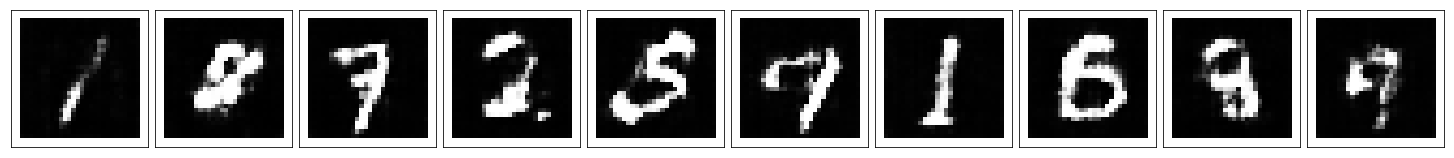

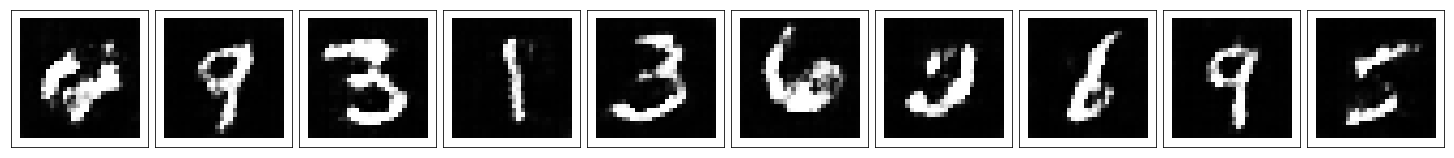

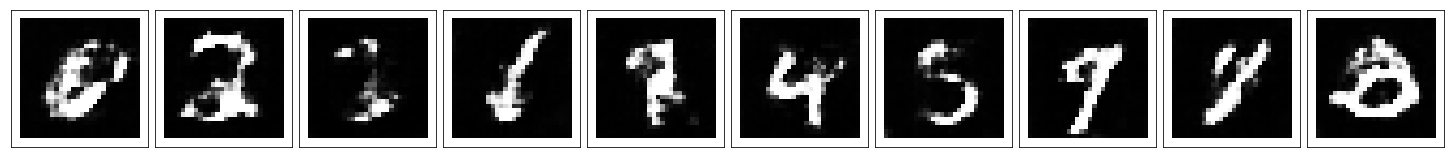

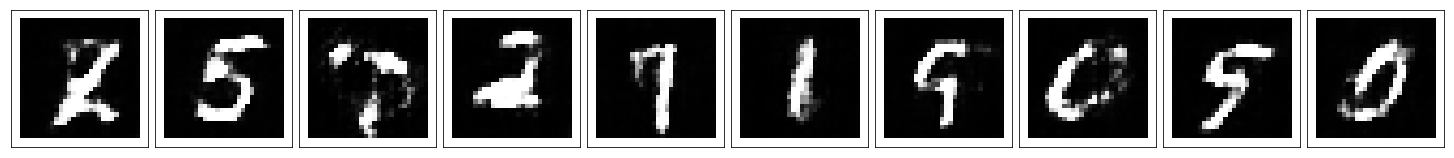

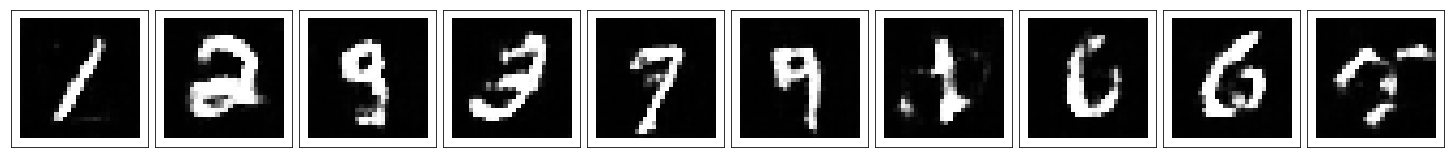

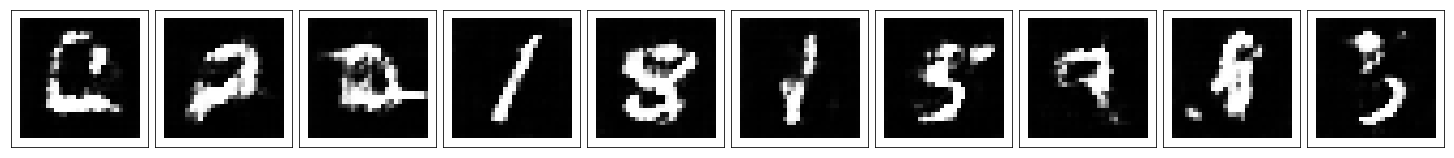

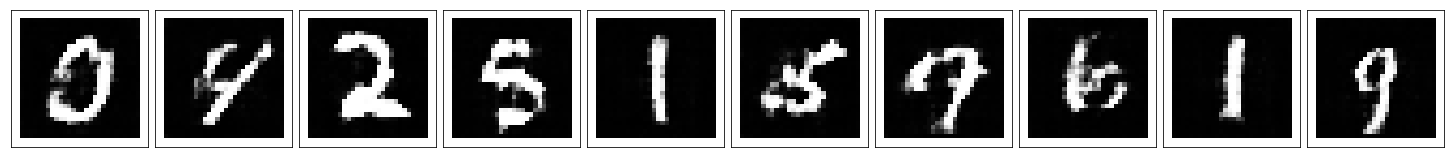

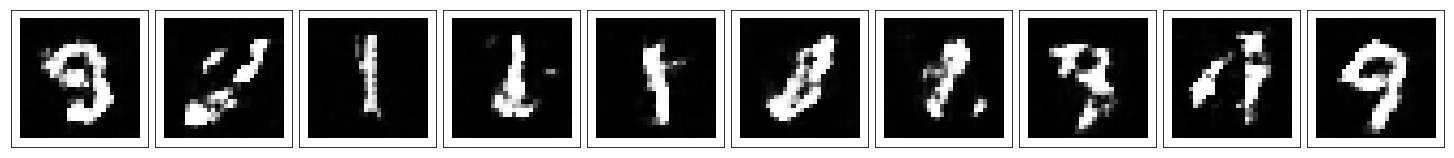

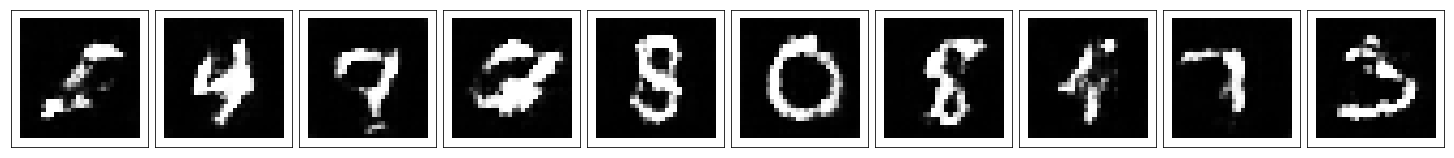

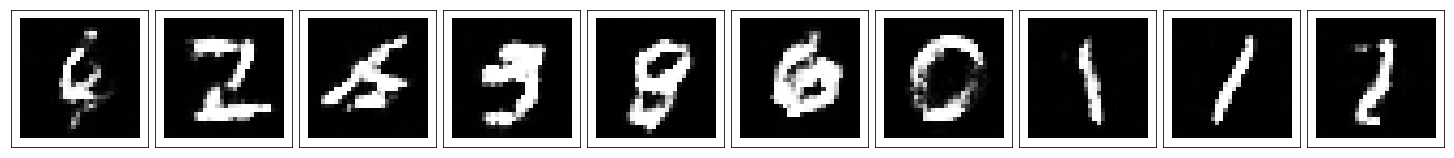

In [11]:
with open('samples_DCgan.pkl', 'rb') as f:
    pic_generate = pickle.load(f)
pp = pic_generate[20:30]
for i in range(len(pp)):
    plot_images(pp[i])
# len(pic_generate)

In [137]:
def get_y_code():
    y_example_code = np.zeros((100,12), dtype=np.float)
    final_codes=[]
    for k in range(10):
        final_codes.append(list(k*np.ones(10)))
    final_codes = np.array(final_codes)
    final_codes = final_codes.reshape(100,-1)
    for i,j in enumerate(final_codes):
        y_example_code[i,int(j[0])]=1.0
    return y_example_code

In [138]:
with open('samples_DCgan_final.pkl', 'rb') as f:
    pic_generate = pickle.load(f)
    
def show_pic_g2(epoch, samples):
    
    fig, axes = plt.subplots(figsize = (20, 80), nrows=20, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [139]:
pic_generate[0].shape

(28, 28)

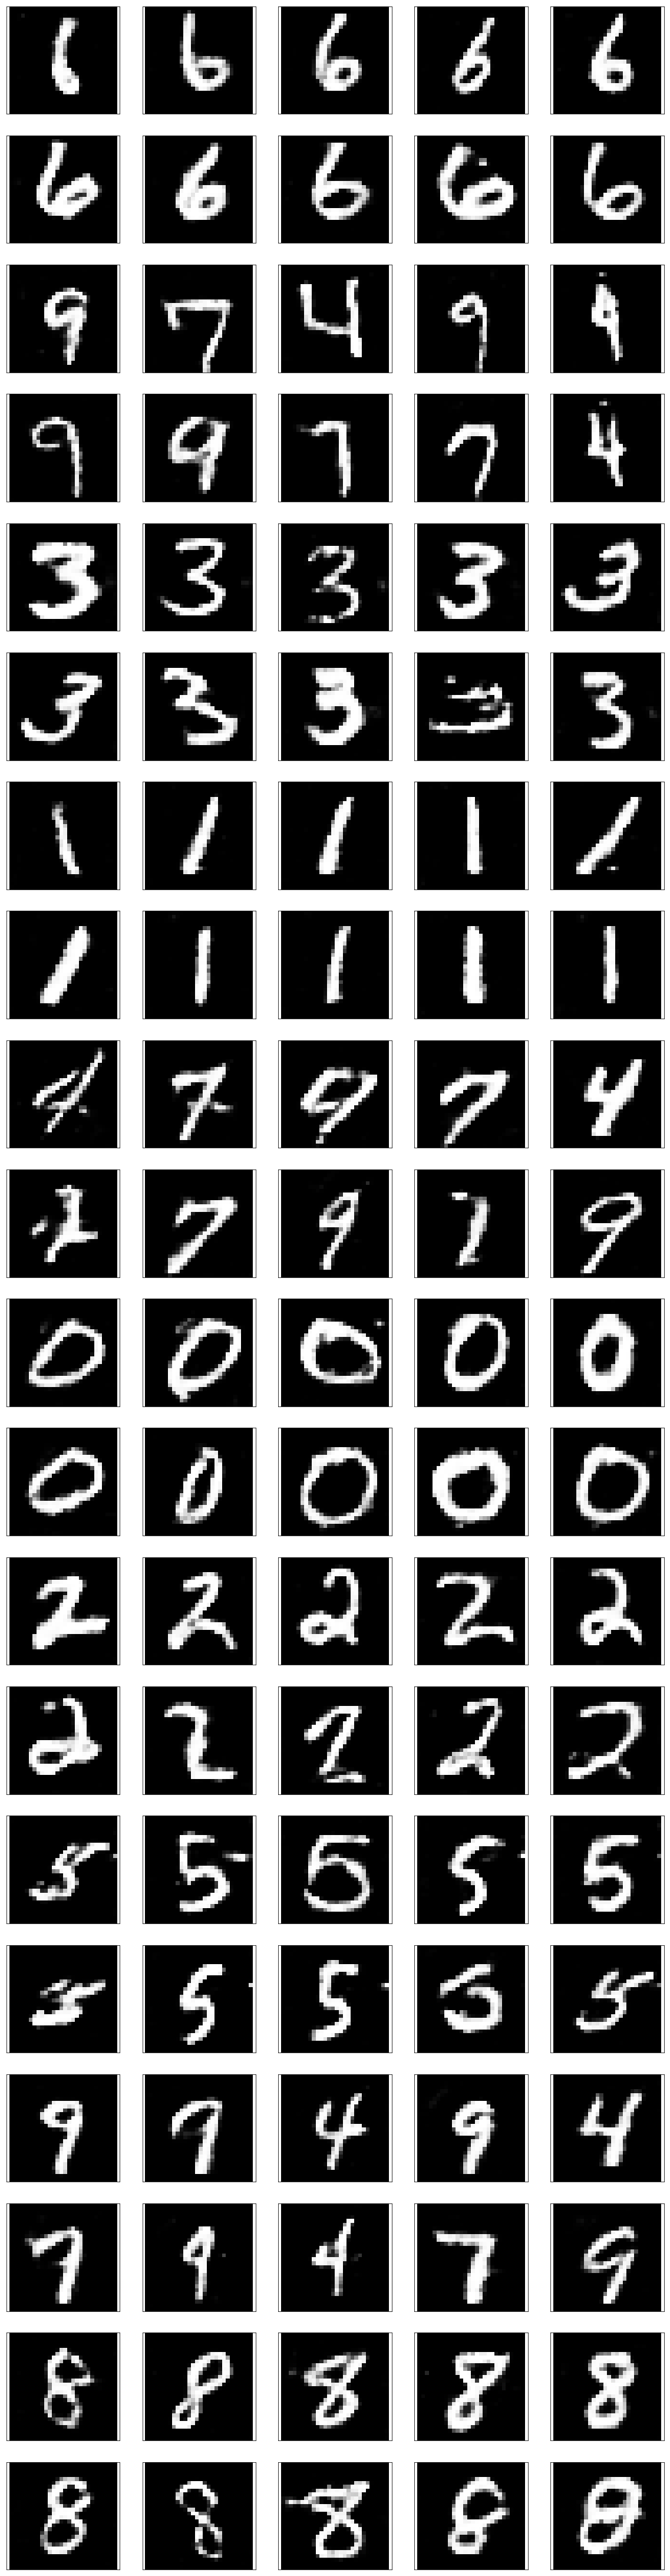

In [140]:
_ = show_pic_g2(1, pic_generate)